In [1]:
%run ../widgets/config_check.py

sys:1: UserWarning: Your current version of bqplot (0.10.5) is older then the one used in tests (0.11). It is recommended to uprgade it.


In [2]:
# <api>
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.special import logsumexp
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl_intro = load_notebook('./Sampling_Intro.ipynb')
smpl_rej = load_notebook('./Sampling_Rejection.ipynb')

# Gibbs Sampling

Gibbs sampling is a technique to sample from a multivariate distribution, e.g. $p(\mathbf{x}) = p(x_1, \ldots, x_D)$ where each sample is a $D$-dimensional vector $\mathbf{x} \in \mathbb{R}^D$. Instead of sampling directly from the full joint distribution, Gibbs sampling considers each coordinate in turn and samples a new value from its conditional distribution, e.g.
$$ p(x_d | x_1,\ldots,x_{d-1},x_{d+1},\ldots,X_D) = p(x_d | \mathbf{x}_{-d}) $$

This Gibbs sampling step can be considered as an adapted Metropolis-Hastings proposal which is always accepted. The multi-variate extension then draws on the observation that MCMC transitions can be combined, either in random or in sequential order, if each individual transition leaves the target density invariant. To see this, consider several transition densities $p_1(x'|x), \ldots, p_K(x'|x)$ and mix them with probabilities $\pi_k$, i.e.
$$ p(x'|x) = \sum_{k=1}^K \pi_k p_k(x'|x) $$
Then,
$$ \int p(x'|x) p^*(x) dx = \int \sum_{k=1}^K \pi_k p_k(x'|x) p^*(x) dx = \sum_{k=1}^K \pi_k \int p_k(x'|x) p^*(x) dx = \sum_{k=1}^K \pi_k p^*(x) = p^*(x) $$
since each $p_k$ leaves the target density $p^*$ invariant.

**Exercise**: Show that Gibbs sampling is a special type of Metropolis-Hastings sampling.

In [3]:
# <api>
class GibbsSampling (smpl_intro.Sampling):
    def __init__ (self, transitions, x):
        self.transitions = transitions
        self.x = x
        
    def sample (self):
        x = self.x[:]
        K = len(self.transitions)
        for i in range(K):
            x[i] = self.transitions[i](x)
        self.x = x
        return x

Gibbs sampling requires that the conditional densities can be sampled from. It is most often used, when these can be computed in closed form, but it can also be combined with other methods such as slice sampling. Below is an illustration of Gibbs sampling for the 2-dimensional Gaussian example.

In [4]:
# <api>
def cond_prob (i, x):
    return np.random.normal(loc=0.99*x[i], scale=np.sqrt(1-0.99**2))

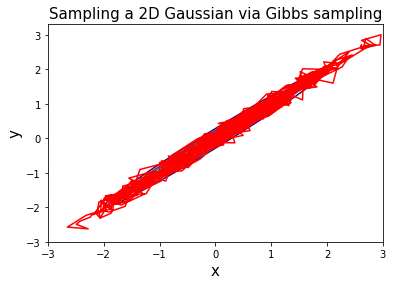

In [5]:
sampling = GibbsSampling([lambda x: cond_prob(1,x), lambda x: cond_prob(0,x)], [1.5,0])

samples = [sampling.sample() for _ in range(1000)]
plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Sampling a 2D Gaussian via Gibbs sampling', fontsize=15)
plt.contour(smpl_rej.X, smpl_rej.Y, smpl_rej.p2d.pdf(smpl_rej.XY));

Gibbs sampling is vastly popular as

* it has no free parameters which need to be tuned
* appears efficient as it moves on every sample, i.e. never rejects

Gibbs sampling is most efficient if all coordinates are almost independent. In the case of high dependencies the conditional distributions are sharply peaked and Gibbs sampling moves slowly across the space. The above example nicely illustrates this effect as the length scale of each move is restricted to the standard deviation $\sqrt{1 - 0.99^2} = 0.141$ of the conditional distribution while the actual distribution has a much larger extend.

__Example__: Gibbs sampling for linear regression

Let $\mathbf{X}$ denote the design matrix, i.e. values of $D$ regressors (plus bias input) for $N$ training cases collected in a $N \times D$ matrix, and $\mathbf{t} \in \mathbb{R}^N$ denote the target outputs.

Linear regression then models the targets as
$$ p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \tau) = \prod_{i=1}^N \mathcal{N}(t_i ; \mathbf{w}^T \mathbf{x}_i, \tau) $$
with weight vector $\mathbf{w}$ and observation noise precision $\tau = \frac{1}{\sigma^2}$.

With conjugate priors the conditional posterior distributions can be computed analytically:
* $\mathbf{w}$: Conjugate prior is Gaussian with mean $\mathbf{0}$ and covariance $\Sigma_0$
  
  Posterior is also Gaussian with covariance
  $$ \Sigma_N = ( \Sigma_0^{-1} + \tau \mathbf{X}^T \mathbf{X} )^{-1} $$
  and mean
  $$ \mu_N = \tau \Sigma_N \mathbf{X}^T \mathbf{t} $$
* $\tau$: Conjugate prior is Gamma with shape $\alpha_0$ and rate $\beta_0$

  Posterior is again a Gamma distribution with shape $\alpha_N = \alpha_0 + \frac{N}{2}$ and rate $\beta_N = \beta_0 + \frac{1}{2} (\mathbf{t} - \mathbf{X} \mathbf{w})^T (\mathbf{t} - \mathbf{X} \mathbf{w})$
  
The program below implements the Gibbs updates according to the above formulas

In [6]:
# <api>
def lm_Gibbs_w (sample, X, t, Sigma_0_inv):
    # Compute posterior covariance
    tau = sample[1]
    Sigma_N = np.linalg.inv( Sigma_0_inv + tau*np.dot(X.T, X) )
    # and mean
    mu_N = tau*np.dot(Sigma_N, np.dot(X.T, t))
    # Draw new weight vector for next sample
    w_new = np.random.multivariate_normal(mu_N.squeeze(), Sigma_N, size=1)
    return w_new.T

def lm_Gibbs_tau (sample, X, t, alpha_0, beta_0):
    # Compute posterior shape
    N, D = X.shape
    alpha_N = alpha_0 + 0.5*N
    # and rate
    w = sample[0]
    err = t - np.dot(X, w)
    beta_N = beta_0 + 0.5*np.dot(err.T, err).squeeze()
    # Draw new precision for next sample
    tau_new = np.random.gamma(alpha_N, 1.0/beta_N, size=1)
    return tau_new

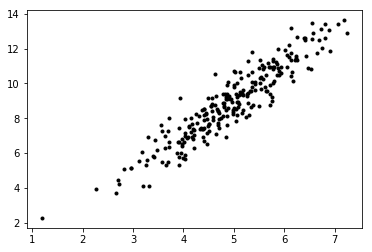

In [7]:
# Small demo data set
N = 250
x = np.hstack([np.ones((N,1)), 5+np.random.normal(size=(N,1))])
t = (np.dot(x, np.array([-1,2])) + np.random.normal(size=(N,), scale=0.8))[:,np.newaxis]
plt.plot(x[:,1], t, 'k.');

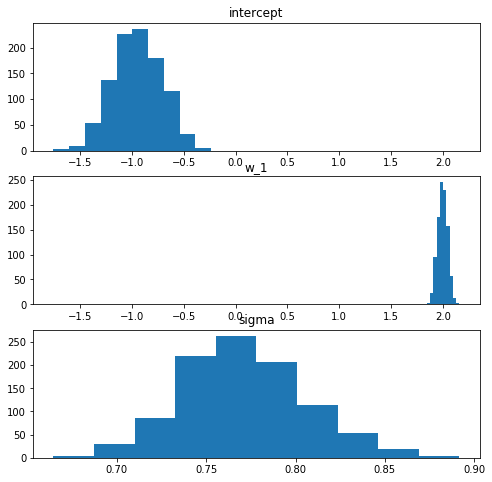

In [8]:
# Hyper parameters
N, D = x.shape
alpha_0 = beta_0 = 0.01;
Sigma_0_inv = np.linalg.inv( np.eye(D) )

# Gibbs samples
w = np.reshape(np.zeros(D), (D,1))
sampling = GibbsSampling([lambda s: lm_Gibbs_w(s, x, t, Sigma_0_inv), 
                          lambda s: lm_Gibbs_tau(s, x, t, alpha_0, beta_0)],
                         [w, 1.0])

samples = [sampling.sample() for _ in range(1000)]

# Plot histogramm of weights and precision
plt.figure(figsize=(8, 8))
ax = plt.subplot(311)
plt.hist(list(map(lambda x: float(x[0][0]), samples)))
plt.title('intercept')
plt.subplot(312, sharex=ax)
plt.hist(list(map(lambda x: float(x[0][1]), samples)))
plt.title('w_1')
plt.subplot(313)
plt.hist(list(map(lambda x: 1.0/np.sqrt(float(x[1])), samples)))
plt.title('sigma');

**Exercise**: Define a Gibbs sampler which samples each weight individually. What are the advantages/disadvantages of this approach?